## Exploratory Data Analysis of datasets

In [12]:
# import packages
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter

### SQuAD2.0 dataset

In [2]:
# Import SQuAD2.0 train and dev sets seperately directly from the specified path

def load_squad_dataset(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        squad_dict = json.load(f)

    data = []
    for article in squad_dict['data']:
        for paragraph in article['paragraphs']:
            context = paragraph['context']
            for qa in paragraph['qas']:
                question = qa['question']
                qid = qa['id']
                is_impossible = qa.get('is_impossible', False)

                if is_impossible:
                    answers = []
                else:
                    answers = [ans['text'] for ans in qa['answers']]

                data.append({
                    'id': qid,
                    'question': question,
                    'context': context,
                    'answers': answers,
                    'is_impossible': is_impossible
                })

    return pd.DataFrame(data)

# File paths
train_file = 'data/SQuAD2/SQuAD2_train-v2.0.json'
dev_file = 'data/SQuAD2/SQuAD2_dev-v2.0.json'

# Load datasets
train_df = load_squad_dataset(train_file)
dev_df = load_squad_dataset(dev_file)

# Display sample
print(train_df.head())

                         id  \
0  56be85543aeaaa14008c9063   
1  56be85543aeaaa14008c9065   
2  56be85543aeaaa14008c9066   
3  56bf6b0f3aeaaa14008c9601   
4  56bf6b0f3aeaaa14008c9602   

                                            question  \
0           When did Beyonce start becoming popular?   
1  What areas did Beyonce compete in when she was...   
2  When did Beyonce leave Destiny's Child and bec...   
3      In what city and state did Beyonce  grow up?    
4         In which decade did Beyonce become famous?   

                                             context                answers  \
0  Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...    [in the late 1990s]   
1  Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...  [singing and dancing]   
2  Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...                 [2003]   
3  Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...       [Houston, Texas]   
4  Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...           [late 1990s]   

 

Saved dataset summary to tables/SQuAD/squad2_summary_stats.csv


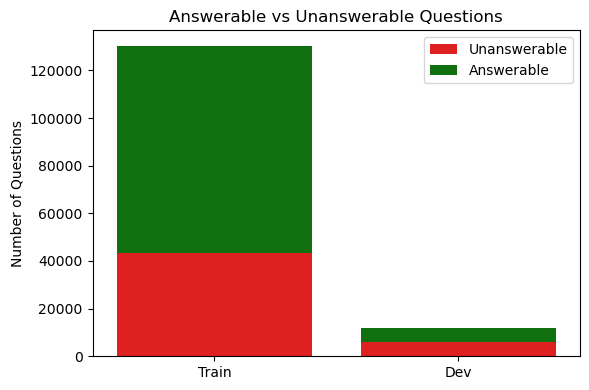

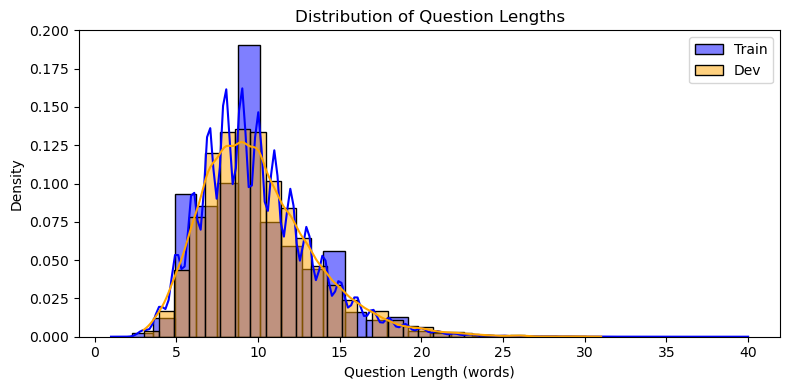

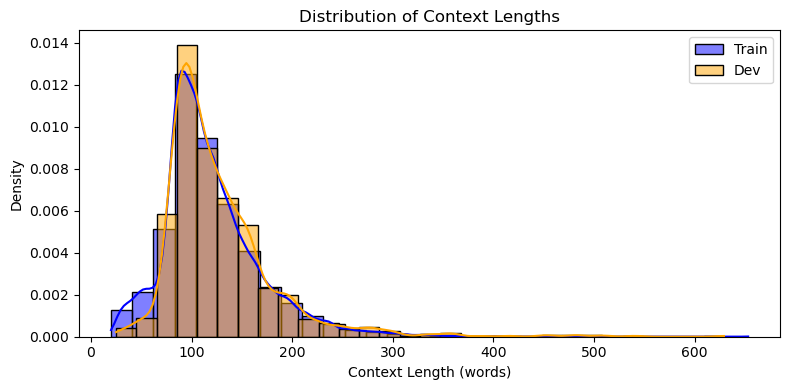

  Dataset  Total Questions  Answerable Questions  Unanswerable Questions  \
0   Train           130319                 86821                   43498   
1     Dev            11873                  5928                    5945   

   Avg Answers per Answerable Question  Avg Question Length (words)  \
0                             1.000000                     9.893822   
1                             3.424764                    10.019624   

   Avg Context Length (words)  
0                  119.614316  
1                  127.907184  


In [ ]:
# Create output folders if they don't exist
os.makedirs("figures/SQuAD", exist_ok=True)
os.makedirs("tables/SQuAD", exist_ok=True)

# Function to compute dataset stats
def compute_stats(df, name):
    total_questions = len(df)
    unanswerable_count = df['is_impossible'].sum()
    answerable_count = total_questions - unanswerable_count
    avg_answers_per_question = df[df['is_impossible'] == False]['answers'].apply(len).mean()
    avg_question_length = df['question'].apply(lambda x: len(x.split())).mean()
    avg_context_length = df['context'].apply(lambda x: len(x.split())).mean()

    return {
        'Dataset': name,
        'Total Questions': total_questions,
        'Answerable Questions': answerable_count,
        'Unanswerable Questions': unanswerable_count,
        'Avg Answers per Answerable Question': avg_answers_per_question,
        'Avg Question Length (words)': avg_question_length,
        'Avg Context Length (words)': avg_context_length
    }

# Compute stats
train_stats = compute_stats(train_df, "Train")
dev_stats = compute_stats(dev_df, "Dev")
stats_df = pd.DataFrame([train_stats, dev_stats])

# Save stats table
stats_df.to_csv("tables/SQuAD/squad2_summary_stats.csv", index=False)
print("Saved dataset summary to tables/SQuAD/squad2_summary_stats.csv")

# ----------- Visualization 1: Answerable vs Unanswerable ------------
plt.figure(figsize=(6, 4))
sns.barplot(x=["Train", "Dev"],
            y=[train_stats['Unanswerable Questions'], dev_stats['Unanswerable Questions']],
            color="red", label="Unanswerable")
sns.barplot(x=["Train", "Dev"],
            y=[train_stats['Answerable Questions'], dev_stats['Answerable Questions']],
            color="green",
            bottom=[train_stats['Unanswerable Questions'], dev_stats['Unanswerable Questions']],
            label="Answerable")
plt.ylabel("Number of Questions")
plt.title("Answerable vs Unanswerable Questions")
plt.legend()
plt.tight_layout()
plt.savefig("figures/SQuAD/answerable_vs_unanswerable.png")
plt.show()

# ----------- Visualization 2: Question Length Distribution ------------
plt.figure(figsize=(8, 4))
sns.histplot(train_df['question'].apply(lambda x: len(x.split())), kde=True, bins=30, label='Train', color='blue', stat="density")
sns.histplot(dev_df['question'].apply(lambda x: len(x.split())), kde=True, bins=30, label='Dev', color='orange', stat="density")
plt.xlabel("Question Length (words)")
plt.ylabel("Density")
plt.title("Distribution of Question Lengths")
plt.legend()
plt.tight_layout()
plt.savefig("figures/SQuAD/question_length_distribution.png")
plt.show()

# ----------- Visualization 3: Context Length Distribution ------------
plt.figure(figsize=(8, 4))
sns.histplot(train_df['context'].apply(lambda x: len(x.split())), kde=True, bins=30, label='Train', color='blue', stat="density")
sns.histplot(dev_df['context'].apply(lambda x: len(x.split())), kde=True, bins=30, label='Dev', color='orange', stat="density")
plt.xlabel("Context Length (words)")
plt.ylabel("Density")
plt.title("Distribution of Context Lengths")
plt.legend()
plt.tight_layout()
plt.savefig("figures/SQuAD/context_length_distribution.png")
plt.show()

print(stats_df)

In [25]:
# --- Create example instance table ---
example = train_df[train_df['answers'].apply(lambda x: len(x) > 0)].iloc[0]
example_table = pd.DataFrame({
    "Title": ["N/A (SQuAD 2.0)"],
    "Context": [example['context']],
    "Question": [example['question']],
    "Answer": [example['answers'][0]]
})

example_table.to_csv("tables/SQuAD/squad2_example_instance.csv", index=False)

In [26]:
example_table

,Title,Context,Question,Answer
0,N/A (SQuAD 2.0),Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce start becoming popular?,in the late 1990s


In [37]:
# Concatenate text of all rows in each column
all_context_text = ' '.join(train_df["context"].tolist())
all_question_text = ' '.join(train_df["question"].tolist())
all_answer_text = ' '.join(train_df["answers"].apply(lambda x: ' '.join(x)).tolist())

# Calculate word frequency using Counter
context_word_freq = Counter(all_context_text.split())
question_word_freq = Counter(all_question_text.split())
answer_word_freq = Counter(all_answer_text.split())

# Get the top 15 most frequent words for each column
top_context_words = dict(context_word_freq.most_common(15))
top_question_words = dict(question_word_freq.most_common(15))
top_answer_words = dict(answer_word_freq.most_common(15))

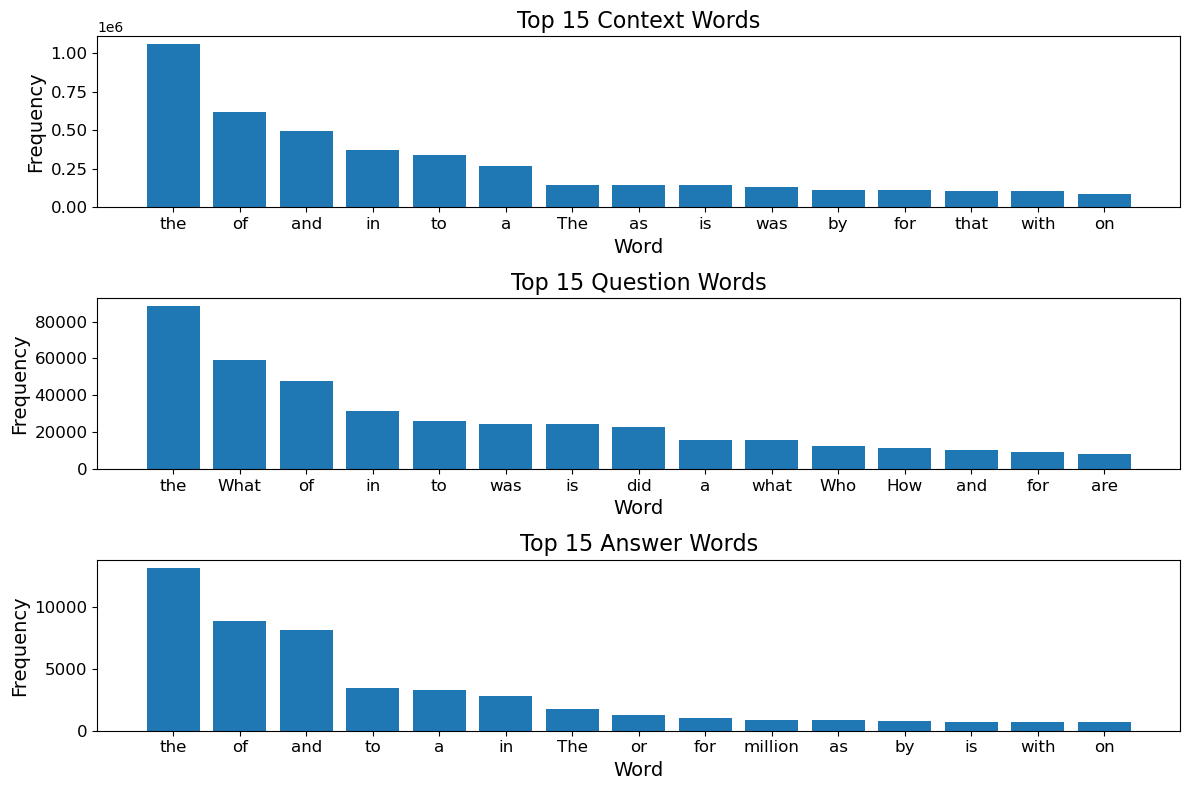

In [39]:
# Plot bar plots
fig, axs = plt.subplots(3, 1, figsize=(12, 8))

axs[0].bar(top_context_words.keys(), top_context_words.values())
axs[0].set_title("Top 15 Context Words", fontsize=16)
axs[0].set_xlabel("Word", fontsize=14)
axs[0].set_ylabel("Frequency", fontsize=14)
axs[0].tick_params(axis='both', which='major', labelsize=12)

axs[1].bar(top_question_words.keys(), top_question_words.values())
axs[1].set_title("Top 15 Question Words", fontsize=16)
axs[1].set_xlabel("Word", fontsize=14)
axs[1].set_ylabel("Frequency", fontsize=14)
axs[1].tick_params(axis='both', which='major', labelsize=12)

axs[2].bar(top_answer_words.keys(), top_answer_words.values())
axs[2].set_title("Top 15 Answer Words", fontsize=16)
axs[2].set_xlabel("Word", fontsize=14)
axs[2].set_ylabel("Frequency", fontsize=14)
axs[2].tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.savefig("figures/SQuAD/train_word_frequency")
plt.show()

In [31]:
# Function to generate word cloud from word frequency and save the plot
def generate_wordcloud_and_save(word_freq, filename):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.savefig(f"figures/SQuAD/{filename}")
    plt.close()
    plt.show()

# Generate word clouds and save plots
generate_wordcloud_and_save(context_word_freq, "context_wordcloud.png")
generate_wordcloud_and_save(question_word_freq, "question_wordcloud.png")